In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [3]:
data=pd.concat([train,test],axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 0 to 83999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   252000 non-null  object
 1   income               252000 non-null  int64 
 2   age                  252000 non-null  int64 
 3   experience_years     252000 non-null  int64 
 4   is_married           252000 non-null  object
 5   city                 252000 non-null  int64 
 6   region               252000 non-null  int64 
 7   current_job_years    252000 non-null  int64 
 8   current_house_years  252000 non-null  int64 
 9   house_ownership      252000 non-null  object
 10  car_ownership        252000 non-null  object
 11  profession           252000 non-null  int64 
 12  label                252000 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 26.9+ MB


In [4]:
data.head()

,id,income,age,experience_years,is_married,city,region,current_job_years,current_house_years,house_ownership,car_ownership,profession,label
0,train_0,8529345,44,2,single,210,0,2,10,rented,no,13,0
1,train_1,7848654,55,9,single,229,2,9,13,rented,no,43,0
2,train_2,8491491,61,20,single,114,28,8,11,rented,no,12,0
3,train_3,8631544,69,13,married,276,14,13,12,rented,no,27,0
4,train_4,6947233,62,10,single,56,11,10,12,rented,no,47,0


In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
cate_cols = ['is_married','car_ownership', 'house_ownership', ]
for col in cate_cols:
    lb = LabelEncoder()
    data[col] = lb.fit(data[col])
    train[col] = lb.transform(train[col])
    test[col] = lb.transform(test[col])

In [7]:
no_feas = ['id', 'label']
features = [col for col in train.columns if col not in no_feas]
X_train = train[features]
X_test = test[features]

y_train = train['label'].astype(int)

In [8]:
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import ensemble
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from  sklearn import linear_model 
from sklearn import naive_bayes 
from sklearn import neighbors 
from sklearn import svm
from sklearn import tree
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [11]:
MLA = [
    #集成方法
    ensemble.AdaBoostClassifier(),
    ensemble.RandomForestClassifier(),
    lgb.LGBMClassifier(),

    #高斯过程
    linear_model.LogisticRegressionCV(),

    #贝叶斯
    naive_bayes.GaussianNB(),
    
    #KNN算法
    neighbors.KNeighborsClassifier(),
    
    #支持向量机-SVM
    svm.LinearSVC(),
    
    #决策树模型    
    tree.DecisionTreeClassifier(),
    
    #奇异值分析
    XGBClassifier()    
    ]

In [12]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
train['pred']=-1
MLA_predict = train['pred']

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, X_train, 
                                                y_train, 
                                                cv  = cv_split,
                                                return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, y_train)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index+=1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

AdaBoostClassifier
RandomForestClassifier
LGBMClassifier
LogisticRegressionCV
GaussianNB
KNeighborsClassifier
LinearSVC
DecisionTreeClassifier
XGBClassifier
[11:28:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'erro

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.940189,0.898456,0.00313841,8.31313
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.904129,0.888659,0.00417993,0.368988
8,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.896591,0.887808,0.00339841,1.5988
7,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.940205,0.880214,0.00287517,0.395648
2,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.881064,0.879599,0.00256862,0.211111
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.877181,0.877143,0.002523,2.28806
3,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.876996,0.876923,0.0024674,1.98613
4,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.876996,0.876923,0.0024674,0.0469651
6,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.694815,0.694823,0.84781,13.1488


Text(0, 0.5, 'Algorithm')

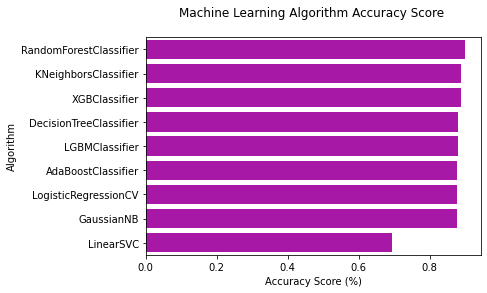

In [13]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [14]:
cat_params = {'learning_rate': 0.1, 'depth': 9, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False,'verbose':0}
model = CatBoostClassifier(iterations=20,**cat_params)
cv_results = model_selection.cross_validate(model, X_train, 
                                                y_train, 
                                                cv  = cv_split,
                                                return_train_score=True)

In [15]:
cv_results['test_score'].mean() 

0.8769226190476191

In [16]:
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),   
    ('knn', neighbors.KNeighborsClassifier()),
    ('xgb', XGBClassifier()),
    ('cat',CatBoostClassifier(iterations=10,**cat_params)),
    ('lgb',lgb.LGBMClassifier()),
    ('dtc',tree.DecisionTreeClassifier())
]

In [17]:
#权重投票
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X_train, y_train, cv  = cv_split)
vote_soft.fit(X_train, y_train)

[11:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:34:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

VotingClassifier(estimators=[('ada', AdaBoostClassifier()),
                             ('rfc', RandomForestClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                 

In [18]:
print("Soft Voting Test w/bin score mean: {:.2f}".format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}".format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting Test w/bin score mean: 89.03
Soft Voting Test w/bin score 3*std: +/- 0.36
----------


In [19]:
predictions=vote_soft.predict(X_test)

In [20]:
from sklearn.metrics import mean_squared_error
y_test = test['label'].astype(int)
mean_squared_error(y_test, predictions)

0.10857142857142857

In [21]:
print('准确率: ', metrics.accuracy_score(y_test,predictions))

准确率:  0.8914285714285715


In [22]:
test.head()

,id,income,age,experience_years,is_married,city,region,current_job_years,current_house_years,house_ownership,car_ownership,profession,label
0,test_0,4260981,47,18,1,118,0,7,13,2,0,39,0
1,test_1,1537266,78,13,1,73,22,9,12,2,0,50,0
2,test_2,4716686,74,11,1,96,25,9,10,0,0,1,0
3,test_3,4245860,34,3,1,232,14,3,11,2,0,6,0
4,test_4,493379,66,6,1,145,28,6,11,2,1,28,0


In [23]:
probability=vote_soft.predict_proba(X_test)[:,1]

In [24]:
sub = pd.read_csv('./sample_submit.csv')
sub['label'] = probability
sub[['id','label']].to_csv('./sub.csv', index=None)

In [25]:
sub

,id,label
0,test_0,0.150663
1,test_1,0.119156
2,test_2,0.158125
3,test_3,0.140633
4,test_4,0.197719
...,...,...
83995,test_83995,0.138240
83996,test_83996,0.126745
83997,test_83997,0.136181
83998,test_83998,0.453706


In [26]:
roc_auc_score(y_test, probability)

0.934964216597386